In [249]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from time import time

## Michaelis-Menten kinetics

this is a rather simple stochastic network, good place to start the research project. I read it from *Warne MFML Oct 2020*. 

It describe the catalytic conversion of a substrate $S$ into product $P$ with presense of the enzymatic reaction involving enzyme $E$. 

$$
E + S \xrightarrow{k_1} [ES], \quad [ES] \xrightarrow{k_2} E+S, \quad [ES] \xrightarrow{k_3} E+P
$$

The parameters here are 
- kinetic rates $k_i,i=1,2,3$
- initial copy number of $E,S$

The observation is the copy number of $P$ at some time $t$. 

#### CME

The transition of state is governed by the chemical master equation 

$$
\frac{d p(x_t|x_s)}{dt} = \sum_{j=1}^M a_j(x_t - v_j) p(x_t - v_j | x_s) - a_j(x_t) p(x_t|x_s)
$$

#### propensity 

propensity function has the form 

$$
a_j (X_t) = k_j \cdot (X_{i,t}) \cdot (X_{i,t}-1) \cdots (X_{i,t}-v_{i,j}^- + 1)
$$


#### (todo) additive error for observation


## the inference problem

calculate $\mathbb E[k_3|Y_{obs}]$ for $Y_{obs} = [y_{obs}(t_1), y_{obs}(t_2),\cdots,y_{obs}(t_4)], t_i = 20i$


# Outline

Now with the basic problem statement. I am going to 
1. build a class of stochastic kinetics that can be used to model the MM kinetics. 
2. implement the simulation methods of gilespie or tau-leaping. 
3. do the inference with MCMC, although I haven't understood on how to do it yet. 

In [250]:
class Stochastic_Kinetics:
    '''
    This models the stochastic network of chemical reactions, 
    
    # the paramters
    - number of species = N
    - number of reactions = M
    - reactions stochio :has: shape(M,2,N)
    - kinetic rates :has: shape(M)
    
    # the methods
    - __init__
    - 
    '''
    
    def __init__(
        self,
        kinetic_rates,
        reactions,
        chemicals, 
    ):
        '''
        - kinetic_rates: shape (N)
        - chemicals: arr of str, len(arr) = N
        - reactions: arr of tuple of dict with key in chemicals and positive integer values
        '''
        
        self.chemicals = chemicals
        self.N = len(chemicals)
        self.index2chemical = dict(list(enumerate(chemicals)))
        self.chemical2index = {v:k for k,v in self.index2chemical.items()}
        
        self.M = len(reactions)
        
        self.r_input = np.array([self.dict2vec(d) for d,_ in reactions])
        self.r_output = np.array([self.dict2vec(d) for _,d in reactions])
        self.r_diff = self.r_output - self.r_input
        self.r_k_rates = np.array(kinetic_rates)
        
    def dict2vec(self,d):
        ret = np.zeros(self.N)
        for k,v in d.items():
            ret[self.chemical2index[k]] = v
        return ret
    
    def product(self,a,b):
        if b == 0:
            return 1
        if a-b+1 <=1:
            return 0
        else:
            return np.product(np.arange(a,a-b,-1))
    
    def propensity(self,X):
        return self.r_k_rates * np.array([np.product([self.product(a,b) for a,b in zip(X,j)]) for j in self.r_input]) 
    
    def gilespie1(self,X):
        A = self.propensity(X)
        a = np.sum(A)
        dt = np.random.exponential(scale=1/a)
        dX = self.r_diff[np.random.choice(self.M,p=A/a)]
        return dt,dX
    
    def tau_leaping1(self,X,tau):
        A = self.propensity(X)
        dX = (np.random.poisson(tau*A)[:,np.newaxis]*self.r_diff).sum(axis=0)
        return tau, dX

I have basically built the tau-leaping and gilespie for a stochastic chemical reaction network this far. the only thing is that this class lacks the flexibility of setting arbitrary parameters. as it would be the case useful when doing the inference. maybe I should just give bunch of utility functions and let people able to just plugin what-ever the data with the right shape, instead of having a class for it. 

In [251]:
chemicals = 'S E ES P'.split()
kinetic_rates = (1e-3,5e-3,1e-2)
reactions = [
    ({'E':1,'S':1},     {'ES':1}),
    ({'ES':1},          {'E':1,'S':1}),
    ({'ES':1},          {'E':1,'P':1})]

X_init = {
    'E': 1000,
    'S': 1000}

In [252]:
model = Stochastic_Kinetics(kinetic_rates,reactions,chemicals)

In [253]:
X_init_vec = model.dict2vec(X_init)

In [255]:
## 100 steps of gilespie
T = [0]
X_arr = [X_init_vec]
t = time()
while T[-1] < 80:
    dt,dX = model.gilespie1(X_arr[-1])
    T.append(T[-1]+dt)
    X_arr.append(X_arr[-1] + dX)
    
time()-t


0.09431099891662598

In [256]:
T = np.array(T)
X_arr = np.array(X_arr)

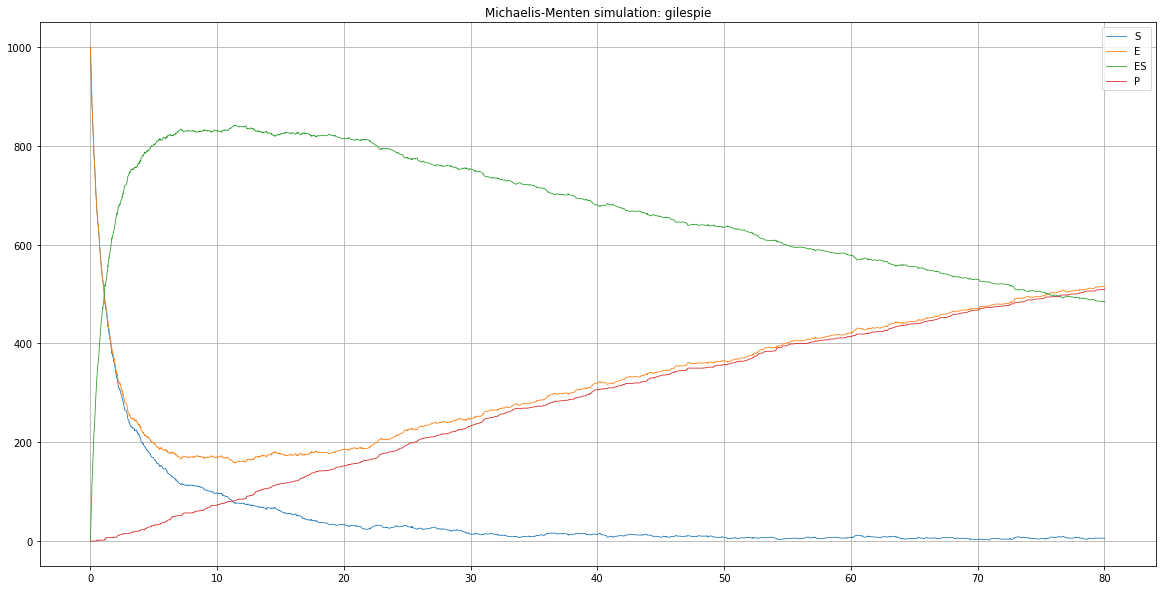

In [276]:
plt.figure(figsize=(20,10))
for i,s in enumerate(chemicals):
    plt.plot(T,X_arr[:,i],label=s,linewidth=.8)
plt.title('Michaelis-Menten simulation: gilespie')
plt.grid()
plt.legend()

This graph compared to the Warne's shows that my algorithm should be correct. 

In [273]:
## 100 steps of tau-leaping
T_ = [0]
X_arr_ = [X_init_vec]
tau = .5
t = time()
while T_[-1] < 80:
    dt,dX = model.tau_leaping1(X_arr_[-1],tau)
    T_.append(T_[-1]+dt)
    X_arr_.append(X_arr_[-1] + dX)
T_ = np.array(T_)
X_arr_ = np.array(X_arr_)
time() -t

0.007536888122558594

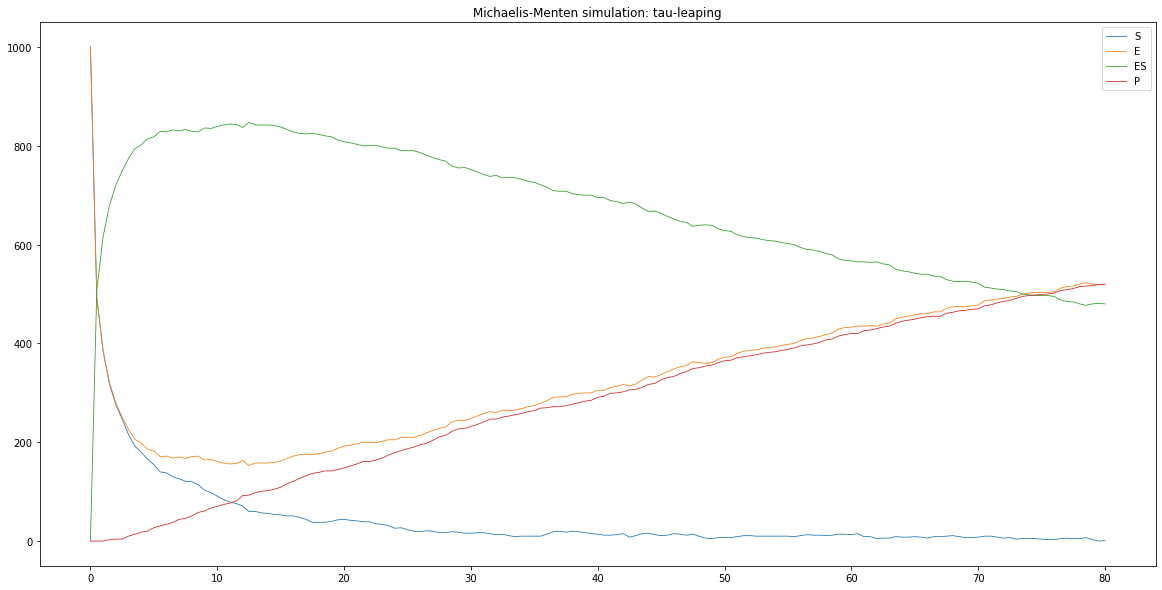

In [274]:
plt.figure(figsize=(20,10))
for i,s in enumerate(chemicals):
    plt.plot(T_,X_arr_[:,i],label=s,linewidth=.8)
plt.title('Michaelis-Menten simulation: tau-leaping')
plt.legend()


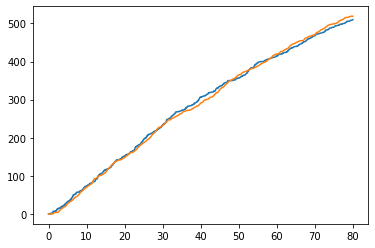

In [275]:
plt.plot(T,X_arr[:,-1])
plt.plot(T_,X_arr_[:,-1])

---

## What about reversing the stochastic simulation? 

Given a SDE 

$$
\frac{dx(t)}{dt} = F(x(t)) + G(x(t))W_t
$$

I can sample it both forward and backward. So know if I have certain observations and some estimated parameter $\theta$. 

--- 


## thoughts
1. saving the likelyhood by refering to what have been computed
2. multi-particle MCMC